In [1]:
import os,time,glob,sys
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torch import nn

from torch.utils.data import Dataset, DataLoader
from utils import *

from model import U_Net_Generator
from model import Discriminator

In [2]:
#torch.cuda.set_device(0)
os.environ["CUDA_VISIBILE_DEVICES"] = '0,1,2'

G_output_path = ('./G_checkpoint/')
D_output_path = ('./D_checkpoint/')

if not os.path.exists(G_output_path):
    os.makedirs(G_output_path)

if not os.path.exists(D_output_path):
    os.makedirs(D_output_path)    
    
#history_file = ('./history/history.pth')
dataset_dir = ('../train2D3D/train/')
   
input_list = sorted(glob.glob(os.path.join(dataset_dir, "input/*.npy")))
output_list = sorted(glob.glob(os.path.join(dataset_dir, "output/*.npy")))
#print(input_list)
#print(output_list)
X_train, X_valid, y_train, y_valid = train_test_split(input_list, output_list, test_size=0.11,random_state=35)

#print(X_train)
#print(y_train)
#print(X_train)
train_data = Dataset3d(X_train,y_train)
valid_data = Dataset3d(X_valid,y_valid)

#A = train_data.__getitem__(1)
#print(A[0])

train_losses = []
valid_losses = []

avg_train_losses = []
avg_valid_losses = []

early_stopping = EarlyStopping(patience=20, verbose=True, result_dir=model_output_path)

In [3]:
batch_size = 2
epochs = 100

D = Discriminator().cuda()
G = U_Net_Generator().cuda()
D = nn.DataParallel(D,device_ids=[0,1,2])
G = nn.DataParallel(G,device_ids=[0,1,2])

d_optimizer = torch.optim.Adam(D.parameters(), lr=1e-4 ,weight_decay=1e-6)
g_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4 ,weight_decay=1e-6)

criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss().cuda()

#total_params = sum(p.numel() for p in model.parameters())
#print(f'{total_params:,} total parameter.')

dataloader_train = DataLoader(train_data,batch_size,shuffle=True)
dataloader_valid = DataLoader(valid_data,batch_size,shuffle=True)

45,841,949 total parameter.


In [4]:
def to_variable(x, requires_grad = True):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad)

"""
if os.path.exists(history_file):
    checkpoint = torch.load(history_file)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch']
    print('load epoch {} successfully'.format(start_epoch))
    
else:
    start_epoch = 0
    print('no saved model, train from scratch')
"""

for epoch in range(epochs):
    model.train()
    for i, (img, real_video) in enumerate(dataloader_train):
        #print('Epoch:{} | num:{} | data_shape:{} | label_shape:{}'.format(epoch,i,data.size(),label.size()))
        
        img = Variable(img).cuda().float()
        #label = torch.squeeze(label)
        real_video = Variable(real_video).cuda().float()
        #print('real_img_shape{}'.format(real_img.size()))
        real_label = to_variable(torch.LongTensor(np.ones(batchSize, dtype = int)), requires_grad = False)
        fake_label = to_variable(torch.LongTensor(np.zeros(batchSize, dtype = int)), requires_grad = False)
        
        # Discriminator train 
        real_out = D(real_video)
        d_loss_real = criterion(real_out, real_label)
        real_scores = real_out
        
        fake_video = G(img).detach()
        fake_out = D(fake_video)
        d_loss_fake = criterion(fake_out, fake_label)
        fake_scores = fake_out
        
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # Generator train 
        fake_video = G(img)
        output = D(fake_video)
        g_mse_loss = nn.MSELoss(fake_video, real_video)*10
        g_loss = criterion(output, real_label) + g_mse_loss
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
              
        train_losses.append(g_loss.item())
        if (i+1) % 20 == 0:
            print('Epoch:', epoch, 'Iter', i, 'Train_loss:', loss.item())

    #evaluation
    model.eval()
    with torch.no_grad():
        for i, (img, real_video) in enumerate(dataloader_valid):
            img = Variable(img).cuda().float()
            #label = torch.squeeze(label)
            real_video = Variable(real_video).cuda().float()
            fake_video = G(img)
            output = D(fake_video)
            #pred = torch.squeeze(pred)
            g_mse_loss = nn.MSELoss(fake_video, real_video)*10
            g_val_loss = criterion(output, real_label) + g_mse_loss
 
            valid_losses.append(g_val_loss.item())

    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    
    #last_train_losses.append(train_loss[-1])
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    epoch_len = len(str(epochs))
    print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}]'+
                f'train_loss:{train_loss:.5f}'+
                f'valid_loss:{valid_loss:.5f}')
    
    print(print_msg)
    
    train_losses = []
    valid_losses = []
    
    early_stopping(valid_loss, G)
    
    if early_stopping.early_stop:
        print('Early stopping')
        break
    state = {'model':G.state_dict(), 'optimizer':g_optimizer.state_dict(), 'epoch':epoch}
    torch.save(state, history_file)
    #torch.save(model.state_dict(), model_output_path+'epoch_%d.pth'%(epoch))


no saved model, train from scratch
Epoch: 0 Iter 19 Train_loss: 0.003860319731757045
Epoch: 0 Iter 39 Train_loss: 0.002400939352810383
Epoch: 0 Iter 59 Train_loss: 0.001738624065183103
Epoch: 0 Iter 79 Train_loss: 0.0018319766968488693
Epoch: 0 Iter 99 Train_loss: 0.0011994453379884362
Epoch: 0 Iter 119 Train_loss: 0.0010930723510682583
Epoch: 0 Iter 139 Train_loss: 0.001053541898727417
Epoch: 0 Iter 159 Train_loss: 0.001280846307054162
Epoch: 0 Iter 179 Train_loss: 0.0009932882385328412
Epoch: 0 Iter 199 Train_loss: 0.0008485711296088994
Epoch: 0 Iter 219 Train_loss: 0.0010615827050060034
Epoch: 0 Iter 239 Train_loss: 0.000733082415536046
Epoch: 0 Iter 259 Train_loss: 0.0007653427892364562
Epoch: 0 Iter 279 Train_loss: 0.0007625942234881222
Epoch: 0 Iter 299 Train_loss: 0.0006758671370334923
Epoch: 0 Iter 319 Train_loss: 0.000746016507036984
Epoch: 0 Iter 339 Train_loss: 0.0007792756077833474
Epoch: 0 Iter 359 Train_loss: 0.0006829961785115302
Epoch: 0 Iter 379 Train_loss: 0.000770485

Epoch: 2 Iter 959 Train_loss: 0.00036649464163929224
Epoch: 2 Iter 979 Train_loss: 0.00042932346696034074
Epoch: 2 Iter 999 Train_loss: 0.00039318008930422366
Epoch: 2 Iter 1019 Train_loss: 0.00036267799441702664
Epoch: 2 Iter 1039 Train_loss: 0.0005297793541103601
Epoch: 2 Iter 1059 Train_loss: 0.0003707322757691145
[  2/100]train_loss:0.00041valid_loss:0.00041
Validation loss decreased (0.000453 --> 0.000413).  Saving model ...
Epoch: 3 Iter 19 Train_loss: 0.0003464403562247753
Epoch: 3 Iter 39 Train_loss: 0.0004074102034792304
Epoch: 3 Iter 59 Train_loss: 0.00035100162494927645
Epoch: 3 Iter 79 Train_loss: 0.0003288763982709497
Epoch: 3 Iter 99 Train_loss: 0.00037121440982446074
Epoch: 3 Iter 119 Train_loss: 0.000359410943929106
Epoch: 3 Iter 139 Train_loss: 0.00035293822293169796
Epoch: 3 Iter 159 Train_loss: 0.0003687366843223572
Epoch: 3 Iter 179 Train_loss: 0.0003765181463677436
Epoch: 3 Iter 199 Train_loss: 0.000399526470573619
Epoch: 3 Iter 219 Train_loss: 0.000370636058505624

Epoch: 5 Iter 779 Train_loss: 0.0003282076504547149
Epoch: 5 Iter 799 Train_loss: 0.00032083041151054204
Epoch: 5 Iter 819 Train_loss: 0.00034558234619908035
Epoch: 5 Iter 839 Train_loss: 0.00038053534808568656
Epoch: 5 Iter 859 Train_loss: 0.0003024791949428618
Epoch: 5 Iter 879 Train_loss: 0.00038380431942641735
Epoch: 5 Iter 899 Train_loss: 0.0003388583136256784
Epoch: 5 Iter 919 Train_loss: 0.00032948050647974014
Epoch: 5 Iter 939 Train_loss: 0.0003103483759332448
Epoch: 5 Iter 959 Train_loss: 0.0002949774789158255
Epoch: 5 Iter 979 Train_loss: 0.00037920119939371943
Epoch: 5 Iter 999 Train_loss: 0.00034985211095772684
Epoch: 5 Iter 1019 Train_loss: 0.0003238807839807123
Epoch: 5 Iter 1039 Train_loss: 0.00030868829344399273
Epoch: 5 Iter 1059 Train_loss: 0.0004209483740851283
[  5/100]train_loss:0.00034valid_loss:0.00034
Validation loss decreased (0.000369 --> 0.000340).  Saving model ...
Epoch: 6 Iter 19 Train_loss: 0.0003934211272280663
Epoch: 6 Iter 39 Train_loss: 0.000378860044

Epoch: 8 Iter 599 Train_loss: 0.00029098583036102355
Epoch: 8 Iter 619 Train_loss: 0.00027751404559239745
Epoch: 8 Iter 639 Train_loss: 0.0003160088381264359
Epoch: 8 Iter 659 Train_loss: 0.00029739568708464503
Epoch: 8 Iter 679 Train_loss: 0.0002532482030801475
Epoch: 8 Iter 699 Train_loss: 0.00028331458452157676
Epoch: 8 Iter 719 Train_loss: 0.0002590969670563936
Epoch: 8 Iter 739 Train_loss: 0.0003023133613169193
Epoch: 8 Iter 759 Train_loss: 0.0002799698559101671
Epoch: 8 Iter 779 Train_loss: 0.00027889697230421007
Epoch: 8 Iter 799 Train_loss: 0.0002735483867581934
Epoch: 8 Iter 819 Train_loss: 0.00028166608535684645
Epoch: 8 Iter 839 Train_loss: 0.00030560456798411906
Epoch: 8 Iter 859 Train_loss: 0.0003264923579990864
Epoch: 8 Iter 879 Train_loss: 0.00031276760273613036
Epoch: 8 Iter 899 Train_loss: 0.00029112424817867577
Epoch: 8 Iter 919 Train_loss: 0.00033705413807183504
Epoch: 8 Iter 939 Train_loss: 0.00031280884286388755
Epoch: 8 Iter 959 Train_loss: 0.0003870878426823765
E

Epoch: 11 Iter 419 Train_loss: 0.0002762777148745954
Epoch: 11 Iter 439 Train_loss: 0.00026055690250359476
Epoch: 11 Iter 459 Train_loss: 0.00027922019944526255
Epoch: 11 Iter 479 Train_loss: 0.00029892034945078194
Epoch: 11 Iter 499 Train_loss: 0.0003472555836196989
Epoch: 11 Iter 519 Train_loss: 0.0002525754680391401
Epoch: 11 Iter 539 Train_loss: 0.000262852554442361
Epoch: 11 Iter 559 Train_loss: 0.0003000217257067561
Epoch: 11 Iter 579 Train_loss: 0.0002926667802967131
Epoch: 11 Iter 599 Train_loss: 0.00025837536668404937
Epoch: 11 Iter 619 Train_loss: 0.00024831006885506213
Epoch: 11 Iter 639 Train_loss: 0.0003711448225658387
Epoch: 11 Iter 659 Train_loss: 0.0003123295318800956
Epoch: 11 Iter 679 Train_loss: 0.0002938737743534148
Epoch: 11 Iter 699 Train_loss: 0.0003058289585169405
Epoch: 11 Iter 719 Train_loss: 0.00026659498689696193
Epoch: 11 Iter 739 Train_loss: 0.0003309982712380588
Epoch: 11 Iter 759 Train_loss: 0.0003177290491294116
Epoch: 11 Iter 779 Train_loss: 0.00026540

Epoch: 14 Iter 199 Train_loss: 0.0002166198391932994
Epoch: 14 Iter 219 Train_loss: 0.000247171672526747
Epoch: 14 Iter 239 Train_loss: 0.0002553472586441785
Epoch: 14 Iter 259 Train_loss: 0.0002521095739211887
Epoch: 14 Iter 279 Train_loss: 0.00023709515517111868
Epoch: 14 Iter 299 Train_loss: 0.0002519069821573794
Epoch: 14 Iter 319 Train_loss: 0.00027155125280842185
Epoch: 14 Iter 339 Train_loss: 0.0002687644155230373
Epoch: 14 Iter 359 Train_loss: 0.0002494950604159385
Epoch: 14 Iter 379 Train_loss: 0.0002585461479611695
Epoch: 14 Iter 399 Train_loss: 0.0002702415513340384
Epoch: 14 Iter 419 Train_loss: 0.00025792085216380656
Epoch: 14 Iter 439 Train_loss: 0.0002590602380223572
Epoch: 14 Iter 459 Train_loss: 0.0002578800776973367
Epoch: 14 Iter 479 Train_loss: 0.00027041893918067217
Epoch: 14 Iter 499 Train_loss: 0.000259249412920326
Epoch: 14 Iter 519 Train_loss: 0.00023873175086919218
Epoch: 14 Iter 539 Train_loss: 0.00028130310238339007
Epoch: 14 Iter 559 Train_loss: 0.000288822

[ 16/100]train_loss:0.00026valid_loss:0.00032
EarlyStopping counter: 2 out of 20
Epoch: 17 Iter 19 Train_loss: 0.0002861390239559114
Epoch: 17 Iter 39 Train_loss: 0.0002634353004395962
Epoch: 17 Iter 59 Train_loss: 0.00020676484564319253
Epoch: 17 Iter 79 Train_loss: 0.0002443699340801686
Epoch: 17 Iter 99 Train_loss: 0.0002567683986853808
Epoch: 17 Iter 119 Train_loss: 0.00023623266315553337
Epoch: 17 Iter 139 Train_loss: 0.0002701368648558855
Epoch: 17 Iter 159 Train_loss: 0.0002309224655618891
Epoch: 17 Iter 179 Train_loss: 0.0002654653799254447
Epoch: 17 Iter 199 Train_loss: 0.00027698741178028286
Epoch: 17 Iter 219 Train_loss: 0.000254279759246856
Epoch: 17 Iter 239 Train_loss: 0.0002604022447485477
Epoch: 17 Iter 259 Train_loss: 0.0002800876391120255
Epoch: 17 Iter 279 Train_loss: 0.0002216290740761906
Epoch: 17 Iter 299 Train_loss: 0.00022378863650374115
Epoch: 17 Iter 319 Train_loss: 0.00024443049915134907
Epoch: 17 Iter 339 Train_loss: 0.00025765562895685434
Epoch: 17 Iter 359

Epoch: 19 Iter 879 Train_loss: 0.0002412749017821625
Epoch: 19 Iter 899 Train_loss: 0.0003226921253371984
Epoch: 19 Iter 919 Train_loss: 0.00024495567777194083
Epoch: 19 Iter 939 Train_loss: 0.00022659794194623828
Epoch: 19 Iter 959 Train_loss: 0.00024851164198480546
Epoch: 19 Iter 979 Train_loss: 0.00021991001267451793
Epoch: 19 Iter 999 Train_loss: 0.0002163282479159534
Epoch: 19 Iter 1019 Train_loss: 0.0002624576154630631
Epoch: 19 Iter 1039 Train_loss: 0.00024165620561689138
Epoch: 19 Iter 1059 Train_loss: 0.0002727921528276056
[ 19/100]train_loss:0.00025valid_loss:0.00028
EarlyStopping counter: 1 out of 20
Epoch: 20 Iter 19 Train_loss: 0.00025664365966804326
Epoch: 20 Iter 39 Train_loss: 0.00025554292369633913
Epoch: 20 Iter 59 Train_loss: 0.00022840309247840196
Epoch: 20 Iter 79 Train_loss: 0.00025508349062874913
Epoch: 20 Iter 99 Train_loss: 0.0002334315504413098
Epoch: 20 Iter 119 Train_loss: 0.00025223271222785115
Epoch: 20 Iter 139 Train_loss: 0.00022057477326598018
Epoch: 20

Epoch: 22 Iter 659 Train_loss: 0.0002627979847602546
Epoch: 22 Iter 679 Train_loss: 0.00020863943791482598
Epoch: 22 Iter 699 Train_loss: 0.00028181920060887933
Epoch: 22 Iter 719 Train_loss: 0.00022934220032766461
Epoch: 22 Iter 739 Train_loss: 0.00020598947594407946
Epoch: 22 Iter 759 Train_loss: 0.00026595877716317773
Epoch: 22 Iter 779 Train_loss: 0.00023124401923269033
Epoch: 22 Iter 799 Train_loss: 0.00020908938313368708
Epoch: 22 Iter 819 Train_loss: 0.0001911060098791495
Epoch: 22 Iter 839 Train_loss: 0.00022928773250896484
Epoch: 22 Iter 859 Train_loss: 0.00022900948533788323
Epoch: 22 Iter 879 Train_loss: 0.00031126823159866035
Epoch: 22 Iter 899 Train_loss: 0.00023806747049093246
Epoch: 22 Iter 919 Train_loss: 0.0002245515352115035
Epoch: 22 Iter 939 Train_loss: 0.00022364399046637118
Epoch: 22 Iter 959 Train_loss: 0.00021068615023978055
Epoch: 22 Iter 979 Train_loss: 0.00021758863294962794
Epoch: 22 Iter 999 Train_loss: 0.00022020396136213094
Epoch: 22 Iter 1019 Train_loss:

Epoch: 25 Iter 439 Train_loss: 0.00024105761258397251
Epoch: 25 Iter 459 Train_loss: 0.00021891255164518952
Epoch: 25 Iter 479 Train_loss: 0.00029329757671803236
Epoch: 25 Iter 499 Train_loss: 0.00043361770804040134
Epoch: 25 Iter 519 Train_loss: 0.00026920143864117563
Epoch: 25 Iter 539 Train_loss: 0.00021142997138667852
Epoch: 25 Iter 559 Train_loss: 0.0002421597164357081
Epoch: 25 Iter 579 Train_loss: 0.00024654733715578914
Epoch: 25 Iter 599 Train_loss: 0.0002714437432587147
Epoch: 25 Iter 619 Train_loss: 0.0002207997313234955
Epoch: 25 Iter 639 Train_loss: 0.00028925773221999407
Epoch: 25 Iter 659 Train_loss: 0.0002400567609583959
Epoch: 25 Iter 679 Train_loss: 0.00023046282876748592
Epoch: 25 Iter 699 Train_loss: 0.0002216415450675413
Epoch: 25 Iter 719 Train_loss: 0.00023195416724774987
Epoch: 25 Iter 739 Train_loss: 0.00026045815320685506
Epoch: 25 Iter 759 Train_loss: 0.00018774830095935613
Epoch: 25 Iter 779 Train_loss: 0.00022523535881191492
Epoch: 25 Iter 799 Train_loss: 0.

Epoch: 28 Iter 239 Train_loss: 0.00021602526248898357
Epoch: 28 Iter 259 Train_loss: 0.0002570634242147207
Epoch: 28 Iter 279 Train_loss: 0.00022843664919491857
Epoch: 28 Iter 299 Train_loss: 0.00021392881171777844
Epoch: 28 Iter 319 Train_loss: 0.00021563553309533745
Epoch: 28 Iter 339 Train_loss: 0.00021495818509720266
Epoch: 28 Iter 359 Train_loss: 0.00021886757167521864
Epoch: 28 Iter 379 Train_loss: 0.00021072196250315756
Epoch: 28 Iter 399 Train_loss: 0.00023181294091045856
Epoch: 28 Iter 419 Train_loss: 0.00026921724202111363
Epoch: 28 Iter 439 Train_loss: 0.00022005710343364626
Epoch: 28 Iter 459 Train_loss: 0.0002172423992305994
Epoch: 28 Iter 479 Train_loss: 0.00022707060270477086
Epoch: 28 Iter 499 Train_loss: 0.00017565068264957517
Epoch: 28 Iter 519 Train_loss: 0.00019723156583495438
Epoch: 28 Iter 539 Train_loss: 0.0002330800925847143
Epoch: 28 Iter 559 Train_loss: 0.00022584959515370429
Epoch: 28 Iter 579 Train_loss: 0.00024292999296449125
Epoch: 28 Iter 599 Train_loss: 

Epoch: 31 Iter 19 Train_loss: 0.0002524421433918178
Epoch: 31 Iter 39 Train_loss: 0.0002608357463032007
Epoch: 31 Iter 59 Train_loss: 0.00026335124857723713
Epoch: 31 Iter 79 Train_loss: 0.0002112951478920877
Epoch: 31 Iter 99 Train_loss: 0.00022372332750819623
Epoch: 31 Iter 119 Train_loss: 0.00019262765999883413
Epoch: 31 Iter 139 Train_loss: 0.00021833140635862947
Epoch: 31 Iter 159 Train_loss: 0.00020804442465305328
Epoch: 31 Iter 179 Train_loss: 0.00018834156799130142
Epoch: 31 Iter 199 Train_loss: 0.00020998578111175448
Epoch: 31 Iter 219 Train_loss: 0.00019007486116606742
Epoch: 31 Iter 239 Train_loss: 0.00025634924531914294
Epoch: 31 Iter 259 Train_loss: 0.0002318347105756402
Epoch: 31 Iter 279 Train_loss: 0.00022060390620026737
Epoch: 31 Iter 299 Train_loss: 0.0001893076696433127
Epoch: 31 Iter 319 Train_loss: 0.00021911048679612577
Epoch: 31 Iter 339 Train_loss: 0.00021533870312850922
Epoch: 31 Iter 359 Train_loss: 0.00021556043066084385
Epoch: 31 Iter 379 Train_loss: 0.00025

Epoch: 33 Iter 899 Train_loss: 0.00023083877749741077
Epoch: 33 Iter 919 Train_loss: 0.00023272287216968834
Epoch: 33 Iter 939 Train_loss: 0.00024007068714126945
Epoch: 33 Iter 959 Train_loss: 0.00023097168013919145
Epoch: 33 Iter 979 Train_loss: 0.0001832258130889386
Epoch: 33 Iter 999 Train_loss: 0.00019823710317723453
Epoch: 33 Iter 1019 Train_loss: 0.0002674011921044439
Epoch: 33 Iter 1039 Train_loss: 0.00018311056192032993
Epoch: 33 Iter 1059 Train_loss: 0.0001985794515348971
[ 33/100]train_loss:0.00022valid_loss:0.00026
EarlyStopping counter: 3 out of 20
Epoch: 34 Iter 19 Train_loss: 0.00022688400349579751
Epoch: 34 Iter 39 Train_loss: 0.0002192923566326499
Epoch: 34 Iter 59 Train_loss: 0.00019712833454832435
Epoch: 34 Iter 79 Train_loss: 0.00023576768580824137
Epoch: 34 Iter 99 Train_loss: 0.0002152103988919407
Epoch: 34 Iter 119 Train_loss: 0.00024062562442850322
Epoch: 34 Iter 139 Train_loss: 0.00022425821225624532
Epoch: 34 Iter 159 Train_loss: 0.00022320567222777754
Epoch: 3

Epoch: 36 Iter 699 Train_loss: 0.00021109463705215603
Epoch: 36 Iter 719 Train_loss: 0.0002557758125476539
Epoch: 36 Iter 739 Train_loss: 0.00022953335428610444
Epoch: 36 Iter 759 Train_loss: 0.00023241518647409976
Epoch: 36 Iter 779 Train_loss: 0.0002076056698570028
Epoch: 36 Iter 799 Train_loss: 0.00021385631407611072
Epoch: 36 Iter 819 Train_loss: 0.00019188577425666153
Epoch: 36 Iter 839 Train_loss: 0.0002591427764855325
Epoch: 36 Iter 859 Train_loss: 0.0001931390434037894
Epoch: 36 Iter 879 Train_loss: 0.00019711934146471322
Epoch: 36 Iter 899 Train_loss: 0.00026093580527231097
Epoch: 36 Iter 919 Train_loss: 0.00021437193208839744
Epoch: 36 Iter 939 Train_loss: 0.00021620573534164578
Epoch: 36 Iter 959 Train_loss: 0.00023451153538189828
Epoch: 36 Iter 979 Train_loss: 0.00023265593335963786
Epoch: 36 Iter 999 Train_loss: 0.0002534901141189039
Epoch: 36 Iter 1019 Train_loss: 0.00020856811897829175
Epoch: 36 Iter 1039 Train_loss: 0.00020315793517511338
Epoch: 36 Iter 1059 Train_loss:

Epoch: 39 Iter 499 Train_loss: 0.00021980841120239347
Epoch: 39 Iter 519 Train_loss: 0.00021722869132645428
Epoch: 39 Iter 539 Train_loss: 0.00021125160856172442
Epoch: 39 Iter 559 Train_loss: 0.00022665323922410607
Epoch: 39 Iter 579 Train_loss: 0.00023497562506236136
Epoch: 39 Iter 599 Train_loss: 0.00023422454250976443
Epoch: 39 Iter 619 Train_loss: 0.00023072099429555237
Epoch: 39 Iter 639 Train_loss: 0.00020966217562090605
Epoch: 39 Iter 659 Train_loss: 0.00020288009545765817
Epoch: 39 Iter 679 Train_loss: 0.00025350399664603174
Epoch: 39 Iter 699 Train_loss: 0.0002229020174127072
Epoch: 39 Iter 719 Train_loss: 0.00019015680300071836
Epoch: 39 Iter 739 Train_loss: 0.00018975100829266012
Epoch: 39 Iter 759 Train_loss: 0.0002050451294053346
Epoch: 39 Iter 779 Train_loss: 0.0002187734644394368
Epoch: 39 Iter 799 Train_loss: 0.00022781602456234396
Epoch: 39 Iter 819 Train_loss: 0.0001838603348005563
Epoch: 39 Iter 839 Train_loss: 0.00021827338787261397
Epoch: 39 Iter 859 Train_loss: 0

Epoch: 42 Iter 299 Train_loss: 0.00019568245625123382
Epoch: 42 Iter 319 Train_loss: 0.0002093182411044836
Epoch: 42 Iter 339 Train_loss: 0.00019620981765910983
Epoch: 42 Iter 359 Train_loss: 0.00019780204456765205
Epoch: 42 Iter 379 Train_loss: 0.0001870434934971854
Epoch: 42 Iter 399 Train_loss: 0.0001955677435034886
Epoch: 42 Iter 419 Train_loss: 0.0002232183760497719
Epoch: 42 Iter 439 Train_loss: 0.00024503516033291817
Epoch: 42 Iter 459 Train_loss: 0.00023542443523183465
Epoch: 42 Iter 479 Train_loss: 0.00021761484094895422
Epoch: 42 Iter 499 Train_loss: 0.00020551387569867074
Epoch: 42 Iter 519 Train_loss: 0.00024481030413880944
Epoch: 42 Iter 539 Train_loss: 0.0002321862557437271
Epoch: 42 Iter 559 Train_loss: 0.00023616956605110317
Epoch: 42 Iter 579 Train_loss: 0.00020686772768385708
Epoch: 42 Iter 599 Train_loss: 0.00018915199325419962
Epoch: 42 Iter 619 Train_loss: 0.00022943671501707286
Epoch: 42 Iter 639 Train_loss: 0.00022530554269906133
Epoch: 42 Iter 659 Train_loss: 0.

Epoch: 45 Iter 99 Train_loss: 0.0001933085877681151
Epoch: 45 Iter 119 Train_loss: 0.00020072066399734467
Epoch: 45 Iter 139 Train_loss: 0.00020690738165285438
Epoch: 45 Iter 159 Train_loss: 0.00018212928262073547
Epoch: 45 Iter 179 Train_loss: 0.0002355904143769294
Epoch: 45 Iter 199 Train_loss: 0.0002014859055634588
Epoch: 45 Iter 219 Train_loss: 0.0001841666962718591
Epoch: 45 Iter 239 Train_loss: 0.000217903740121983
Epoch: 45 Iter 259 Train_loss: 0.00023182693985290825
Epoch: 45 Iter 279 Train_loss: 0.00023403592058457434
Epoch: 45 Iter 299 Train_loss: 0.00020804363884963095
Epoch: 45 Iter 319 Train_loss: 0.00017127017781604081
Epoch: 45 Iter 339 Train_loss: 0.0001969789300346747
Epoch: 45 Iter 359 Train_loss: 0.00023225067707244307
Epoch: 45 Iter 379 Train_loss: 0.00019010910182259977
Epoch: 45 Iter 399 Train_loss: 0.00020097427477594465
Epoch: 45 Iter 419 Train_loss: 0.0002023398847086355
Epoch: 45 Iter 439 Train_loss: 0.00020162021974101663
Epoch: 45 Iter 459 Train_loss: 0.0001

Epoch: 47 Iter 979 Train_loss: 0.00023381758364848793
Epoch: 47 Iter 999 Train_loss: 0.00023094927018973976
Epoch: 47 Iter 1019 Train_loss: 0.00023112387862056494
Epoch: 47 Iter 1039 Train_loss: 0.00019821495516225696
Epoch: 47 Iter 1059 Train_loss: 0.0002088230539811775
[ 47/100]train_loss:0.00021valid_loss:0.00027
EarlyStopping counter: 2 out of 20
Epoch: 48 Iter 19 Train_loss: 0.00024275502073578537
Epoch: 48 Iter 39 Train_loss: 0.0002046144218184054
Epoch: 48 Iter 59 Train_loss: 0.0002144377212971449
Epoch: 48 Iter 79 Train_loss: 0.00025440313038416207
Epoch: 48 Iter 99 Train_loss: 0.00024349337036255747
Epoch: 48 Iter 119 Train_loss: 0.00023821412469260395
Epoch: 48 Iter 139 Train_loss: 0.00022278916731011122
Epoch: 48 Iter 159 Train_loss: 0.00022306233586277813
Epoch: 48 Iter 179 Train_loss: 0.00019784258620347828
Epoch: 48 Iter 199 Train_loss: 0.00019233586499467492
Epoch: 48 Iter 219 Train_loss: 0.0002114021044690162
Epoch: 48 Iter 239 Train_loss: 0.00018052005907520652
Epoch: 

Epoch: 50 Iter 759 Train_loss: 0.00023517492809332907
Epoch: 50 Iter 779 Train_loss: 0.00022385604097507894
Epoch: 50 Iter 799 Train_loss: 0.00024590775137767196
Epoch: 50 Iter 819 Train_loss: 0.00023984727158676833
Epoch: 50 Iter 839 Train_loss: 0.00022914286819286644
Epoch: 50 Iter 859 Train_loss: 0.00019758837879635394
Epoch: 50 Iter 879 Train_loss: 0.0002168109203921631
Epoch: 50 Iter 899 Train_loss: 0.0002565380127634853
Epoch: 50 Iter 919 Train_loss: 0.0001809855893952772
Epoch: 50 Iter 939 Train_loss: 0.00018898236157838255
Epoch: 50 Iter 959 Train_loss: 0.00022598389477934688
Epoch: 50 Iter 979 Train_loss: 0.00022110537975095212
Epoch: 50 Iter 999 Train_loss: 0.00024084099277388304
Epoch: 50 Iter 1019 Train_loss: 0.00025709473993629217
Epoch: 50 Iter 1039 Train_loss: 0.0002439961099298671
Epoch: 50 Iter 1059 Train_loss: 0.00020492463954724371
[ 50/100]train_loss:0.00021valid_loss:0.00027
EarlyStopping counter: 1 out of 20
Epoch: 51 Iter 19 Train_loss: 0.0002574615937191993
Epoc

Epoch: 53 Iter 559 Train_loss: 0.00022729324700776488
Epoch: 53 Iter 579 Train_loss: 0.00019569596042856574
Epoch: 53 Iter 599 Train_loss: 0.0001850477565312758
Epoch: 53 Iter 619 Train_loss: 0.00030392795451916754
Epoch: 53 Iter 639 Train_loss: 0.00021584430942311883
Epoch: 53 Iter 659 Train_loss: 0.0001973901380551979
Epoch: 53 Iter 679 Train_loss: 0.00020702779875136912
Epoch: 53 Iter 699 Train_loss: 0.00018743694818113
Epoch: 53 Iter 719 Train_loss: 0.00016709604824427515
Epoch: 53 Iter 739 Train_loss: 0.00020099099492654204
Epoch: 53 Iter 759 Train_loss: 0.00019291641365271062
Epoch: 53 Iter 779 Train_loss: 0.00020062638213858008
Epoch: 53 Iter 799 Train_loss: 0.0002146325568901375
Epoch: 53 Iter 819 Train_loss: 0.00022669137979391962
Epoch: 53 Iter 839 Train_loss: 0.00022315415844786912
Epoch: 53 Iter 859 Train_loss: 0.00019549955322872847
Epoch: 53 Iter 879 Train_loss: 0.00020446637063287199
Epoch: 53 Iter 899 Train_loss: 0.00018692424055188894
Epoch: 53 Iter 919 Train_loss: 0.0

Epoch: 56 Iter 339 Train_loss: 0.00020108380704186857
Epoch: 56 Iter 359 Train_loss: 0.00017856310296338052
Epoch: 56 Iter 379 Train_loss: 0.0001975570630747825
Epoch: 56 Iter 399 Train_loss: 0.000174490109202452
Epoch: 56 Iter 419 Train_loss: 0.0002060009428532794
Epoch: 56 Iter 439 Train_loss: 0.00021869741613045335
Epoch: 56 Iter 459 Train_loss: 0.000254596903687343
Epoch: 56 Iter 479 Train_loss: 0.00019578676437959075
Epoch: 56 Iter 499 Train_loss: 0.0001938423520186916
Epoch: 56 Iter 519 Train_loss: 0.00018823833670467138
Epoch: 56 Iter 539 Train_loss: 0.00020288863743189722
Epoch: 56 Iter 559 Train_loss: 0.00018772983457893133
Epoch: 56 Iter 579 Train_loss: 0.0002042504056589678
Epoch: 56 Iter 599 Train_loss: 0.00023211205552797765
Epoch: 56 Iter 619 Train_loss: 0.00021138036390766501
Epoch: 56 Iter 639 Train_loss: 0.00019086642714682966
Epoch: 56 Iter 659 Train_loss: 0.00022804732725489885
Epoch: 56 Iter 679 Train_loss: 0.00019660610996652395
Epoch: 56 Iter 699 Train_loss: 0.000

Epoch: 59 Iter 139 Train_loss: 0.00019413464178796858
Epoch: 59 Iter 159 Train_loss: 0.0002733738801907748
Epoch: 59 Iter 179 Train_loss: 0.00018267749692313373
Epoch: 59 Iter 199 Train_loss: 0.00022593268658965826
Epoch: 59 Iter 219 Train_loss: 0.00019680762488860637
Epoch: 59 Iter 239 Train_loss: 0.00020763551583513618
Epoch: 59 Iter 259 Train_loss: 0.0002803968091029674
Epoch: 59 Iter 279 Train_loss: 0.000199948059162125
Epoch: 59 Iter 299 Train_loss: 0.00021012756042182446
Epoch: 59 Iter 319 Train_loss: 0.00019639015954453498
Epoch: 59 Iter 339 Train_loss: 0.00020826059335377067
Epoch: 59 Iter 359 Train_loss: 0.0002115898096235469
Epoch: 59 Iter 379 Train_loss: 0.0002113762457156554
Epoch: 59 Iter 399 Train_loss: 0.00020985963055863976
Epoch: 59 Iter 419 Train_loss: 0.0002070404152618721
Epoch: 59 Iter 439 Train_loss: 0.00020293588750064373
Epoch: 59 Iter 459 Train_loss: 0.0001962047681445256
Epoch: 59 Iter 479 Train_loss: 0.00020660275185946375
Epoch: 59 Iter 499 Train_loss: 0.000

Epoch: 61 Iter 1019 Train_loss: 0.00023325413349084556
Epoch: 61 Iter 1039 Train_loss: 0.0001881939679151401
Epoch: 61 Iter 1059 Train_loss: 0.00020272680558264256
[ 61/100]train_loss:0.00021valid_loss:0.00026
EarlyStopping counter: 7 out of 20
Epoch: 62 Iter 19 Train_loss: 0.00018555005954112858
Epoch: 62 Iter 39 Train_loss: 0.0001725019101286307
Epoch: 62 Iter 59 Train_loss: 0.00017870184092316777
Epoch: 62 Iter 79 Train_loss: 0.00026661509764380753
Epoch: 62 Iter 99 Train_loss: 0.00019664915453176945
Epoch: 62 Iter 119 Train_loss: 0.00026831470313481987
Epoch: 62 Iter 139 Train_loss: 0.00019600565428845584
Epoch: 62 Iter 159 Train_loss: 0.00016882047930266708
Epoch: 62 Iter 179 Train_loss: 0.00018311748863197863
Epoch: 62 Iter 199 Train_loss: 0.00020008475985378027
Epoch: 62 Iter 219 Train_loss: 0.0001783736515790224
Epoch: 62 Iter 239 Train_loss: 0.0002076321979984641
Epoch: 62 Iter 259 Train_loss: 0.00018260657088831067
Epoch: 62 Iter 279 Train_loss: 0.00019089749548584223
Epoch: 

Epoch: 64 Iter 799 Train_loss: 0.0001951272424776107
Epoch: 64 Iter 819 Train_loss: 0.00019364897161722183
Epoch: 64 Iter 839 Train_loss: 0.00021751470922026783
Epoch: 64 Iter 859 Train_loss: 0.00017611256043892354
Epoch: 64 Iter 879 Train_loss: 0.0002520170819479972
Epoch: 64 Iter 899 Train_loss: 0.00017991960339713842
Epoch: 64 Iter 919 Train_loss: 0.00018064292089547962
Epoch: 64 Iter 939 Train_loss: 0.00020559504628181458
Epoch: 64 Iter 959 Train_loss: 0.00018673572049010545
Epoch: 64 Iter 979 Train_loss: 0.000212027138331905
Epoch: 64 Iter 999 Train_loss: 0.00027494484675116837
Epoch: 64 Iter 1019 Train_loss: 0.0002063006832031533
Epoch: 64 Iter 1039 Train_loss: 0.00022049380640964955
Epoch: 64 Iter 1059 Train_loss: 0.00020160280109848827
[ 64/100]train_loss:0.00021valid_loss:0.00026
EarlyStopping counter: 10 out of 20
Epoch: 65 Iter 19 Train_loss: 0.00019501919450704008
Epoch: 65 Iter 39 Train_loss: 0.00023162188881542534
Epoch: 65 Iter 59 Train_loss: 0.00020276090072002262
Epoch

Epoch: 67 Iter 599 Train_loss: 0.00019768709898926318
Epoch: 67 Iter 619 Train_loss: 0.0001825909421313554
Epoch: 67 Iter 639 Train_loss: 0.00023028493160381913
Epoch: 67 Iter 659 Train_loss: 0.00024386937730014324
Epoch: 67 Iter 679 Train_loss: 0.00020637143461499363
Epoch: 67 Iter 699 Train_loss: 0.00024408023455180228
Epoch: 67 Iter 719 Train_loss: 0.0002325513050891459
Epoch: 67 Iter 739 Train_loss: 0.000205847347388044
Epoch: 67 Iter 759 Train_loss: 0.0002164314646506682
Epoch: 67 Iter 779 Train_loss: 0.00019289407646283507
Epoch: 67 Iter 799 Train_loss: 0.00018748649745248258
Epoch: 67 Iter 819 Train_loss: 0.00019262633577454835
Epoch: 67 Iter 839 Train_loss: 0.00017212118837051094
Epoch: 67 Iter 859 Train_loss: 0.00019388335931580514
Epoch: 67 Iter 879 Train_loss: 0.00024716302868910134
Epoch: 67 Iter 899 Train_loss: 0.0002109974157065153
Epoch: 67 Iter 919 Train_loss: 0.00022160736261866987
Epoch: 67 Iter 939 Train_loss: 0.00016169740410987288
Epoch: 67 Iter 959 Train_loss: 0.0

Epoch: 70 Iter 399 Train_loss: 0.00017713778652250767
Epoch: 70 Iter 419 Train_loss: 0.000185938406502828
Epoch: 70 Iter 439 Train_loss: 0.00020656998094636947
Epoch: 70 Iter 459 Train_loss: 0.00018234015442430973
Epoch: 70 Iter 479 Train_loss: 0.0002058217505691573
Epoch: 70 Iter 499 Train_loss: 0.00021509345970116556
Epoch: 70 Iter 519 Train_loss: 0.0002208306541433558
Epoch: 70 Iter 539 Train_loss: 0.00019300733401905745
Epoch: 70 Iter 559 Train_loss: 0.0001975629711523652
Epoch: 70 Iter 579 Train_loss: 0.0002205099444836378
Epoch: 70 Iter 599 Train_loss: 0.00019521625654306263
Epoch: 70 Iter 619 Train_loss: 0.0001992105826502666
Epoch: 70 Iter 639 Train_loss: 0.00019586978305596858
Epoch: 70 Iter 659 Train_loss: 0.00017179302813019603
Epoch: 70 Iter 679 Train_loss: 0.00018135721620637923
Epoch: 70 Iter 699 Train_loss: 0.00021965219639241695
Epoch: 70 Iter 719 Train_loss: 0.0001937725319294259
Epoch: 70 Iter 739 Train_loss: 0.0001980425586225465
Epoch: 70 Iter 759 Train_loss: 0.0001

Epoch: 73 Iter 199 Train_loss: 0.00018566740618553013
Epoch: 73 Iter 219 Train_loss: 0.00019144799443893135
Epoch: 73 Iter 239 Train_loss: 0.0002036505757132545
Epoch: 73 Iter 259 Train_loss: 0.00018393952632322907
Epoch: 73 Iter 279 Train_loss: 0.000217105116462335
Epoch: 73 Iter 299 Train_loss: 0.00021415830997284502
Epoch: 73 Iter 319 Train_loss: 0.00023402526858262718
Epoch: 73 Iter 339 Train_loss: 0.00022540183272212744
Epoch: 73 Iter 359 Train_loss: 0.00019176524074282497
Epoch: 73 Iter 379 Train_loss: 0.00018405802256893367
Epoch: 73 Iter 399 Train_loss: 0.0002487029996700585
Epoch: 73 Iter 419 Train_loss: 0.000220115456613712
Epoch: 73 Iter 439 Train_loss: 0.0003181002102792263
Epoch: 73 Iter 459 Train_loss: 0.0001921240909723565
Epoch: 73 Iter 479 Train_loss: 0.00019197077199351043
Epoch: 73 Iter 499 Train_loss: 0.00018875008390750736
Epoch: 73 Iter 519 Train_loss: 0.00018685820396058261
Epoch: 73 Iter 539 Train_loss: 0.00019013034761883318
Epoch: 73 Iter 559 Train_loss: 0.000

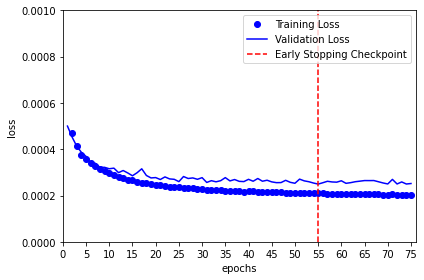

In [5]:
fig = plt.figure(figsize=(6,4))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, 'bo', label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses, 'b', label='Validation Loss')

# find position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.001) # consistent scale
plt.xlim(0, len(avg_valid_losses)+1) # consistent scale

my_x_ticks = np.arange(0, len(avg_valid_losses)+1, 5)
plt.xticks(my_x_ticks)

#plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot_GAN.jpg', nbox_inches='tight')

In [2]:
def to_variable(x, requires_grad = True):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad)

batchSize = 6
real_label = to_variable(torch.LongTensor(np.ones(batchSize, dtype = int)), requires_grad = False)
fake_label = to_variable(torch.LongTensor(np.zeros(batchSize, dtype = int)), requires_grad = False)
print(real_label.size())
print(fake_label)

torch.Size([6])
tensor([0, 0, 0, 0, 0, 0], device='cuda:0')
